# Week 2 - Demonstration Code

Topics covered:
* Datasets
* Basic Neural Networks

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import random
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm.notebook import tqdm

torch.set_printoptions(sci_mode=False)

In [ ]:
def seed_all(seed):
    """Seeds all RNGs with a specific seed value.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Learning to Predict a Linear Function

Is it possible for a neural network to learn how to predict values from a linear function, just from the data itself?

Let's try to see if a neural network can learn how to predict the following function:

$ y = 2x $

To do this, we will need to:
* Create a dataset that creates inputs (x values) and generates ground-truth targets (y values) following the above equation
* Define a neural network that takes a single value, and produces a single value
* Train the neural network with examples from our dataset and observe if it is able to learn from the data

In other words, what we're trying to do is get the neural network to learn what function we used to generate the data, just by only seeing the data!

### The Dataset

Here we define a basic dataset that creates a set of input values with corresponding target values (that are 2x the input values).

In [ ]:
class BasicLinearFunctionDataset(Dataset):
    def __init__(self, n):
        self.input = np.array(range(0, n))
        self.target = self.input * 2

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        input = self.input[idx]
        target = self.target[idx]
        return input, target

In [ ]:
# Let's create an instance of this dataset and observe pairs of input/targets
linear_function_dataset = BasicLinearFunctionDataset(1000)
print(linear_function_dataset[5])
print(linear_function_dataset[10])

(5, 10)
(10, 20)


<font color='red'>Can we write this dataset differently to avoid storing all data ahead of time?</font>

We can! One way to do this is to compute the next value as we need it.

In [ ]:
class BasicLinearFunctionDataset(Dataset):
    def __init__(self, n):
        self.num_items = n

    def __len__(self):
        return self.num_items

    def __getitem__(self, idx):
        input = idx
        target = idx *2 
        return input, target

In [ ]:
linear_function_dataset = BasicLinearFunctionDataset(1000)
print(linear_function_dataset[5])
print(linear_function_dataset[10])

Finally, we need to create a dataloader that uses this dataset so we can automatically batch examples (when training), and gives us the opportunity to enable multiprocessing with our dataloading.

In [ ]:
train_dataloader = DataLoader(linear_function_dataset, batch_size=16, shuffle=True)

# Let's look at one of the batches
input, target = next(iter(train_dataloader))
print('Inputs:', input)
print('Targets:',target)

Inputs: tensor([768,  85, 431, 887, 395, 994,  38, 881, 488, 271, 262, 681, 523, 268,
        782, 144])
Targets: tensor([1536,  170,  862, 1774,  790, 1988,   76, 1762,  976,  542,  524, 1362,
        1046,  536, 1564,  288])


### The Network

Let's define a basic neural network to try to solve our task of predicting the output value, given an input value.

This network should:
* Have 3x linear layers (hidden dimensions can be of any size)
* Accept a single value as input (This value can be positive or negative)
* Output a single value (This value should be allowed to be positive or negative)
* Use ReLU non-linear activations where appropriate


<font color="red">Below is a definition of a model that aims to follow this criteria, but it has some problems! Can you identify all of the mistakes with this model?</font>

In [ ]:
# Here is the bad code with mistakes
# Can you find all the mistakes?
class SimpleModel3Layers(nn.Module):
    def __init__(self, device):
      super().__init__()
      self.linear1 = nn.Linear(10, 20)
      self.linear2 = nn.Linear(50, 10)
      self.to(device)

    def forward(self, x):
      x = self.linear1(x)
      x = self.linear2(x)
      x = nn.ReLU()(nn.Linear(20, 9)(x))
      return x

Below is a mistake-free version of that model

In [ ]:
# Here is code that does not have mistakes
class SimpleModel3Layers(nn.Module):
    def __init__(self, device):
      super().__init__()
      self.linear1 = nn.Linear(1, 5)
      self.linear2 = nn.Linear(5, 2)
      self.linear3 = nn.Linear(2, 1)
      self.to(device)

    def forward(self, x):
      x = nn.ReLU()(self.linear1(x))
      x = nn.ReLU()(self.linear2(x))
      x = self.linear3(x)
      return x

Next, we will choose the correct device to train on, and test that the forward pass through our network works as expected

In [ ]:
device = torch.device("cpu")

# Check if GPU acceleration is available (requires a CUDA-compatible GPU) and
# set the device variable accordingly. If the computer has more than one GPU,
# you can specify which one by replacing 0 with a different index
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

print("Training on", device)

Training on cpu


Code to test the forward pass through the model.

In [ ]:
input, target = next(iter(train_dataloader))
print('Input:', input)

# We need to put the input onto the same device as the model (i.e. cpu or gpu)
input = input.to(device)

# We unsqueeze to get dimensionality: [batch_size, 1]
input = input.unsqueeze(1)

# Here we create an instance of our model and perform a forward pass
model = SimpleModel3Layers(device)
output = model(input.type(torch.float32))

print('Output:', output.squeeze(1))

Input: tensor([531, 528, 275,  47, 110, 135, 910, 783, 304, 520, 190, 869, 220, 766,
         33,  71])
Output: tensor([44.9480, 44.6987, 23.6712,  4.7216,  9.9577, 12.0355, 76.4476, 65.8923,
        26.0815, 44.0338, 16.6067, 73.0400, 19.1001, 64.4794,  3.5581,  6.7163],
       grad_fn=<SqueezeBackward1>)


Once we have created our model, there are also useful ways we can inspect the model to double check what layers are included with our model.

In [ ]:
print(model)

We can also inspect the weights and bias associated to any layer in our network!

Let's inspect the linear3 layer.

<font color="red">Can you draw a diagram of how the weights and bias are used in combination with the previous layer outputs to produce the next set of outputs?</font>

In [ ]:
print(model.linear3.weight)
print(model.linear3.bias)

What about for the linear2 layer?

In [ ]:
print(model.linear2.weight)
print(model.linear2.bias)

What about for the linear1 layer?

In [ ]:
print(model.linear1.weight)
print(model.linear1.bias)

### The Training Loop

Now we have all the bits and pieces needed to train our model. Let's now try training our model to see if it can learn our function!

After running the code cell below, try to modify different parameters to see how that changes your trained model.

In [ ]:
# set the random seed to ensure we get reproducible results
seed_all(1234)

# Define the dataloader that iterates over our dataset
train_dataloader = DataLoader(linear_function_dataset, batch_size=16, shuffle=True)
#train_dataloader = DataLoader(linear_function_dataset_normalised, batch_size=16, shuffle=True)
#train_dataloader = DataLoader(quadratic_function_dataset_normalised, batch_size=16, shuffle=True)
#train_dataloader = DataLoader(advanced_linear_function_dataset_normalised, batch_size=16, shuffle=True)

# Define the criterion function (to compute the loss). What does MSELoss do?
criterion = nn.MSELoss()

# Define the model we want to train
model = SimpleModel3Layers(device)
#model = SimpleModel1Layer(device)
# model = SimpleModel1LayerNoBias(device)

# Define the optimizer we want to use. What does the optimizer do? What about the initial learning rate?
# Does changing the learning rate impact training?
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs we want to train for. An epoch is a complete iteration over our dataset
num_epochs = 200

# Put the model into train mode. What does this do?
model.train()

train_loss = []
for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    loss = 0.0
    for data in train_dataloader:       # Get the next batch from the dataloader
        # 1. Extract the inputs/targets from the batch
        inputs, targets = data

        # 2. Copy the data to the specified device
        inputs, targets = inputs.to(device), targets.to(device)

        # 3. Turn our inputs and targets from dimensionality: [batch_size] to dimensionality: [batch_size, 1] (required by model)
        #    This is not always required, but for this task it is
        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)
        
        # 4. Set all parameter gradients to zero
        optimizer.zero_grad()

        # 5. Have the model make a prediction for the batch
        outputs = model(inputs.type(torch.float32))

        # 6. Compute the loss
        loss = criterion(outputs, targets.type(torch.float32))

        # 7. Backpropagate the loss to compute gradients
        loss.backward()
        
        # 8. Update model weights
        optimizer.step()

        loss += loss.item()

    train_loss.append(loss.detach().cpu().numpy() / len(train_dataloader))

  0%|          | 0/200 [00:00<?, ?it/s]

Let's plot the training loss per-epoch so we can inspect how the model performed. Does this tell us anything about if the model learned from our data?

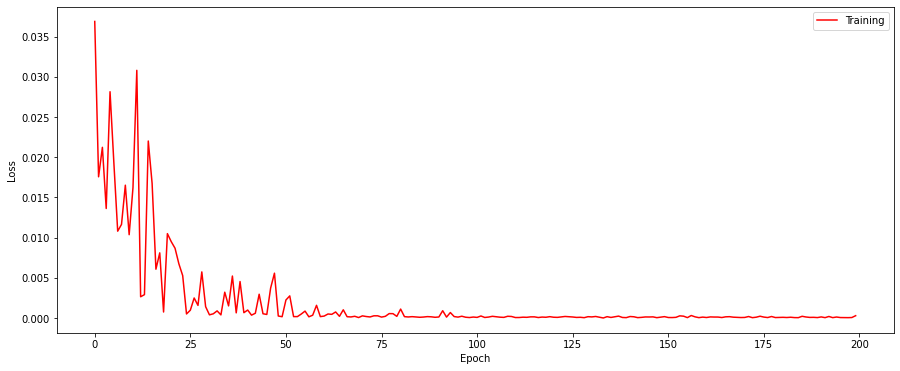

In [ ]:
epochs = range(len(train_loss))
plt.figure(figsize=(15, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epochs, train_loss, 'r-', label='Training')
plt.legend()
plt.show()

Let's now closely inspect exactly how well our trained model actually performs.

Here we sample a batch from our dataloader, make predictions on it with our trained model, and display both the predictions and our targets. Are they similar?

In [ ]:
input, target = next(iter(train_dataloader))
input = input.to(device)
print('Input:', input)
print('\nTarget:', target)
input = input.unsqueeze(1)
output = model(input.type(torch.float32))

print('\nOutput:', output.squeeze(1))

Input: tensor([ 0.7708,  1.0029,  0.9370, -0.7500,  0.6114,  0.1368,  0.3343,  1.7234,
        -0.0398, -1.3146,  0.2511, -1.3077, -1.1830,  0.2650,  1.2142,  0.8574],
       dtype=torch.float64)

Target: tensor([    0.5941,     1.0057,     0.8780,     0.5625,     0.3738,     0.0187,
            0.1117,     2.9701,     0.0016,     1.7282,     0.0631,     1.7101,
            1.3995,     0.0702,     1.4742,     0.7351], dtype=torch.float64)

Output: tensor([ 0.6184,  0.9412,  0.8197,  0.4354,  0.4255, -0.1179,  0.0900,  2.8432,
        -0.0077,  1.7897, -0.0107,  1.7722,  1.4582,  0.0061,  1.5044,  0.7233],
       grad_fn=<SqueezeBackward1>)


### A Modified Dataset

When looking at the loss curve, you might notice that the value of the loss is extremely high!

One reason for this is that the values in our dataset vary by so much (i.e. inputs from 0 to 1000, targets from 0 to 2000), that the scale of the loss can quickly grow. In some cases this can be a problem and cause our model to take a much longer time to converge.

In the code cell below, we redefine the dataset such to ensure that the distribution of our input values have a mean of 0 and standard deviation of 1.

This is achieved by translating all of our input values by:

$ input = \frac{input - \mu}{\sigma} $

Where:
* $\mu$ is the mean of all input values in our dataset
* $\sigma$ is the standard deviation of all inputvalues in our dataset

In [ ]:
class BasicLinearFunctionDatasetNormalised(Dataset):
    def __init__(self, n):
        self.input = np.array(range(0, n))
        self.input_mean = self.input.mean()
        self.input_std = self.input.std()
        self.input = (self.input - self.input_mean) / self.input_std
        self.target = self.input * 2

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        input = self.input[idx]
        target = self.target[idx]
        return input, target

In [ ]:
linear_function_dataset_normalised = BasicLinearFunctionDatasetNormalised(1000)
print(linear_function_dataset_normalised[5])
print(linear_function_dataset_normalised[10])

Let's now recreate the dataloader and try this task again.

<font color="red">Go back to the training loop and modify the dataloader to use the *linear_function_dataset_normalised* dataset object. Retrain your model, and inspect the loss curve and model outputs to see if the model is performing better now</font>

### A Simpler Model
Can we create an even simpler model to solve this task?

Given our task is to learn the linear function $ y = 2x $, can we achieve this with a single linear layer (and no non-linear activation functions)?

In [ ]:
class SimpleModel1Layer(torch.nn.Module):
    def __init__(self, device):
      super().__init__()
      self.linear1 = nn.Linear(1, 1)
      self.to(device)

    def forward(self, x):
      x = self.linear1(x)
      return x

<font color="red">Go back to the training loop and modify the code to use this model. Retrain your model, and inspect the loss curve and model outputs. Was this model sufficient?</font>

Once you've done that, come back here and inspect the weight and bias of the linear layer in the model. What do you think they should be if the model is well converged on this task?

In [ ]:
print(model.linear1.weight)
print(model.linear1.bias)

## Other Tasks

Here are a set of other tasks that you should try to complete

### Learning to Predict a Quadratic Function

Is it possible to get a model to learn a slightly more complex function, such as:

$ y = x^{2} $

Below is a dataset that will return targets in this form.

Before training your model, try to answer these questions:
* Do you think the SimpleModel3Layers model will be able to learn this task?
* If we remove the non-linear activations from the SimpleModel3Layers model, will it be able to learn this task?
* If we use the SimpleModel1Layer model, will it be able to learn this task?

Use this dataset in the training loop above and see if you can answer these questions.

In [ ]:
class BasicQuadraticFunctionDatasetNormalised(Dataset):
    def __init__(self, n):
        self.input = np.array(range(0, n))
        self.input_mean = self.input.mean()
        self.input_std = self.input.std()
        self.input = (self.input - self.input_mean) / self.input_std
        self.target = self.input ** 2

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        input = self.input[idx]
        target = self.target[idx]
        return input, target

In [ ]:
# Create an instance of this dataset and observe pairs of input/targets
quadratic_function_dataset_normalised = BasicQuadraticFunctionDatasetNormalised(1000)
print(quadratic_function_dataset_normalised[5])
print(quadratic_function_dataset_normalised[10])

(-1.7129991051853863, 2.934365934365934)
(-1.695678588449437, 2.875325875325875)


In [ ]:
class SimpleModel3LayersNoActivations(nn.Module):
    def __init__(self, device):
      super().__init__()
      self.linear1 = nn.Linear(1, 5)
      self.linear2 = nn.Linear(5, 2)
      self.linear3 = nn.Linear(2, 1)
      self.to(device)

    def forward(self, x):
      x = self.linear1(x)
      x = self.linear2(x)
      x = self.linear3(x)
      return x

### Learning to Predict a More Advanced Linear Function

What if we modify the linear function to also have a constant, such as:

$ y = 2x + 100 $

Below is a dataset that will return targets in this form.

Before training your model, try to answer these questions:
* Do you think the SimpleModel1Layer model, will it be able to learn this task? If so, what do you think the weight and bias of this model will be if training is successful?
* Do you think an adapted version of the SimpleModel1Layer model (with no bias in the linear layer) will be able to learn this task?

Use this dataset and model in the training loop above and see if you can answer these questions.

In [ ]:
class AdvancedLinearFunctionDatasetNormalised(Dataset):
    def __init__(self, n):
        self.input = np.array(range(0, n))
        self.input_mean = self.input.mean()
        self.input_std = self.input.std()
        self.input = (self.input - self.input_mean) / self.input_std
        self.target = self.input * 2 + 10

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        input = self.input[idx]
        target = self.target[idx]
        return input, target

In [ ]:
advanced_linear_function_dataset_normalised = AdvancedLinearFunctionDatasetNormalised(1000)
print(advanced_linear_function_dataset_normalised[5])
print(advanced_linear_function_dataset_normalised[10])

In [ ]:
class SimpleModel1LayerNoBias(torch.nn.Module):
    def __init__(self, device):
      super().__init__()
      self.linear1 = nn.Linear(1, 1, bias=False)
      self.to(device)

    def forward(self, x):
      x = self.linear1(x)
      return x